# Векторизация вычислений / использование готовых инструментов при помощи numpy

In [1]:
from math import *
import random
import numpy as np

def slow_foo(arr1, arr2):
    res = np.zeros_like(arr1)
    for i in range(len(arr1)):
        if arr1[i] > 0:
            res[i] = arr1[i] * sin(arr2[i]) + arr2[i] + 42
        else:
            res[i] = arr1[i] * cos(arr2[i]) + arr2[i] - 42
    return res

n = 1_000_000
arr1 = np.array([random.uniform(-pi, pi) for i in range(n)])
arr2 = np.array([random.uniform(-pi, pi) for i in range(n)])

In [2]:
%timeit slow_foo(arr1, arr2)

1.48 s ± 6.12 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [6]:
a = np.array([1,2,3,4])
ind = a > 2
a[ind] = 999
ind

array([False, False,  True,  True])

In [3]:
def little_faster(arr1, arr2):
    res = np.zeros_like(arr1)
    cond1 = arr1>0
    res[cond1] = arr1[cond1] * np.sin(arr2[cond1]) + arr2[cond1] + 42
    cond2 = ~cond1
    res[cond2] = arr1[cond2] * np.cos(arr2[cond2]) + arr2[cond2] - 42
    return res

In [4]:
%timeit little_faster(arr1, arr2)

61.3 ms ± 960 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


# JIT – компиляция

In [7]:
from numba import jit
# conda install numba

In [8]:
@jit
def slow_foo_jit(arr1, arr2):
    res = np.zeros_like(arr1)
    for i in range(len(arr1)):
        if arr1[i] > 0:
            res[i] = arr1[i] * sin(arr2[i]) + arr2[i] + 42
        else:
            res[i] = arr1[i] * cos(arr2[i]) + arr2[i] - 42
    return res

slow_foo_jit(arr1, arr2);

In [9]:
%timeit slow_foo_jit(arr1, arr2)

7.02 ms ± 124 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [10]:
from numba import prange

@jit(nopython=True, parallel=True)
def slow_foo_jit2(arr1: np.ndarray, arr2: np.ndarray) -> np.ndarray:
    res = np.zeros_like(arr1)
    for i in prange(arr1.shape[0]):
        if arr1[i] > 0:
            res[i] = arr1[i] * sin(arr2[i]) + arr2[i] + 42
        else:
            res[i] = arr1[i] * cos(arr2[i]) + arr2[i] - 42
    return res

slow_foo_jit2(arr1, arr2);

In [11]:
%timeit slow_foo_jit2(arr1, arr2)

2.99 ms ± 58.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Более подробно про numba [тут](https://numba.pydata.org/)

# Реализация критических функций на компилируемых языках с последующим их подключением через модули

 - Fortran -> Python   [F2Py](https://numpy.org/devdocs/f2py/usage.html)
 - c/c++   -> Python [1](https://habr.com/ru/post/466499/) [2](https://habr.com/ru/post/168083/)
 - Cython

In [ ]:
# pip install Cython

In [12]:
%load_ext Cython

In [15]:
%%cython -a
import numpy as np
from math import *

def slow_foo_cython(arr1, arr2):
    res = np.zeros_like(arr1)
    for i in range(len(arr1)):
        if arr1[i] > 0:
            res[i] = arr1[i] * sin(arr2[i]) + arr2[i] + 42
        else:
            res[i] = arr1[i] * cos(arr2[i]) + arr2[i] - 42
    return res

In [14]:
%timeit slow_foo_cython(arr1, arr2)

1.08 s ± 3.85 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [16]:
%%cython -a
import numpy as np
from math import *
import cython

@cython.boundscheck(False)
@cython.wraparound(False)  
cpdef double[:] slow_foo_cython2(double[:] arr1, double[:] arr2):
    cdef double[:] res = np.zeros_like(arr1)
    cdef int i
    for i in range(len(arr1)):
        if arr1[i] > 0:
            res[i] = arr1[i] * sin(arr2[i]) + arr2[i] + 42
        else:
            res[i] = arr1[i] * cos(arr2[i]) + arr2[i] - 42
    return res

In [17]:
%timeit slow_foo_cython2(arr1, arr2)

110 ms ± 640 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [18]:
%%cython -a
import numpy as np
from libc.math cimport sin, cos
import cython

@cython.boundscheck(False)
@cython.wraparound(False)  
cpdef double[:] slow_foo_cython3(double[:] arr1, double[:] arr2):
    cdef double[:] res = np.empty_like(arr1)
    cdef int i
    for i in range(arr1.shape[0]):
        if arr1[i] > 0:
            res[i] = arr1[i] * sin(arr2[i]) + arr2[i] + 42
        else:
            res[i] = arr1[i] * cos(arr2[i]) + arr2[i] - 42
    return res

In [19]:
%timeit slow_foo_cython3(arr1, arr2)

14 ms ± 33.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [20]:
%%cython -a
# distutils: extra_compile_args = -openmp
import numpy as np
from libc.math cimport sin, cos
import cython
from cython.parallel import prange

@cython.boundscheck(False)
@cython.wraparound(False)  
cpdef void slow_foo_cython5(double[:] arr1, double[:] arr2):
    cdef double[:] res = np.empty_like(arr1)
    cdef int i
    for i in prange(arr1.shape[0], nogil=True):
        if arr1[i] > 0:
            res[i] = arr1[i] * sin(arr2[i]) + arr2[i] + 42
        else:
            res[i] = arr1[i] * cos(arr2[i]) + arr2[i] - 42

In [21]:
%timeit slow_foo_cython5(arr1, arr2)

2.53 ms ± 70 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [22]:
%%cython -a
# distutils: extra_compile_args = -openmp
import numpy as np
from libc.math cimport sin, cos
import cython
from cython.parallel import prange

@cython.boundscheck(False)
@cython.wraparound(False)  
cpdef void slow_foo_cython6(double[:] arr1, double[:] arr2, double[:] res) nogil:
    cdef int i
    for i in prange(arr1.shape[0], nogil=True):
        if arr1[i] > 0:
            res[i] = arr1[i] * sin(arr2[i]) + arr2[i] + 42
        else:
            res[i] = arr1[i] * cos(arr2[i]) + arr2[i] - 42

In [23]:
res = np.zeros_like(arr1)
%timeit slow_foo_cython6(arr1, arr2, res)

1.11 ms ± 42.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## GPU
[CuPy](https://cupy.dev/)

In [24]:
import cupy as cp

In [25]:
a1 = cp.array(arr1)
a2 = cp.array(arr2)
r = cp.array(res)

def cupy_foo(arr1, arr2, res):
    cond1 = arr1>0
    res[cond1] = arr1[cond1] * cp.sin(arr2[cond1]) + arr2[cond1] + 42
    cond2 = ~cond1
    res[cond2] = arr1[cond2] * cp.cos(arr2[cond2]) + arr2[cond2] - 42
    return res

cupy_foo(a1, a2, r);

In [26]:
%timeit cupy_foo(a1, a2, r)

4.18 ms ± 6.37 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [27]:
import torch as T

In [28]:
T.cuda.is_available()

True

In [29]:
a1 = T.tensor(arr1, device='cuda:0')
a2 = T.tensor(arr2, device='cuda:0')
r = T.tensor(res, device='cuda:0')


def pytorch_foo(arr1, arr2, res):
    cond1 = arr1>0
    res[cond1] = arr1[cond1] * T.sin(arr2[cond1]) + arr2[cond1] + 42
    cond2 = ~cond1
    res[cond2] = arr1[cond2] * T.cos(arr2[cond2]) + arr2[cond2] - 42
    return res

pytorch_foo(a1, a2, r);

In [30]:
%timeit pytorch_foo(a1, a2, r)

2.89 ms ± 4.05 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


# Многопоточность

In [31]:
import threading
import time
import random

g1, g2 = 0, 0

def some_foo(name, x):
    print(f'Hello from {name}')
    global g1, g2
    g1, g2 = 0, 0
    for i in range(5):
        g1 = x*(i+1)
        time.sleep(random.uniform(0.5, 1.5))
        g2 = x + g1
        print(f'{name} g2 = {g2}')
        time.sleep(random.uniform(0.1, 0.5))

some_foo('main', 1)
some_foo('main2', 2)

Hello from main
main g2 = 2
main g2 = 3
main g2 = 4
main g2 = 5
main g2 = 6
Hello from main2
main2 g2 = 4
main2 g2 = 6
main2 g2 = 8
main2 g2 = 10
main2 g2 = 12


In [32]:
t1 = threading.Thread(target=some_foo, args=('поток 1', 1))
t2 = threading.Thread(target=some_foo, args=('поток 2', 2))

t1.start()
t2.start()

t1.join()
t2.join()

Hello from поток 1
Hello from поток 2
поток 1 g2 = 3
поток 2 g2 = 4
поток 1 g2 = 5
поток 2 g2 = 5
поток 1 g2 = 4
поток 1 g2 = 7
поток 2 g2 = 7
поток 1 g2 = 6
поток 2 g2 = 10
поток 2 g2 = 12


In [33]:
lock = threading.Lock()

def some_foo2(name, x):
    print(f'Hello from {name}')
    global g1, g2
    g1, g2 = 0, 0
    for i in range(5):
        with lock:
            g1 = x*(i+1)
            time.sleep(random.uniform(0.5, 1.5))
            g2 = x + g1
            print(f'{name} g2 = {g2}')
        time.sleep(random.uniform(0.1, 0.5))
            
t1 = threading.Thread(target=some_foo2, args=('поток 1', 1))
t2 = threading.Thread(target=some_foo2, args=('поток 2', 2))

t1.start()
t2.start()

t1.join()
t2.join()

Hello from поток 1
Hello from поток 2
поток 1 g2 = 1
поток 2 g2 = 4
поток 1 g2 = 3
поток 2 g2 = 6
поток 1 g2 = 4
поток 2 g2 = 8
поток 1 g2 = 5
поток 2 g2 = 10
поток 1 g2 = 6
поток 2 g2 = 12


In [34]:
def threading_computing():
    t1 = threading.Thread(target=slow_foo, args=(arr1, arr2)) 
    t2 = threading.Thread(target=slow_foo, args=(arr1, arr2)) 
    t1.start()
    t2.start()

    t1.join()
    t2.join()

%timeit threading_computing()

2.96 s ± 15.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [35]:
from multiprocessing import Process, Pool

from forsubpro import slow_foo_sub, f

def foo_sub():
    p1 = Process(target=slow_foo_sub, args=(arr1, arr2))
    p2 = Process(target=slow_foo_sub, args=(arr1, arr2))
    p3 = Process(target=slow_foo_sub, args=(arr1, arr2))
    p4 = Process(target=slow_foo_sub, args=(arr1, arr2))
    p5 = Process(target=slow_foo_sub, args=(arr1, arr2))
    
    p1.start()
    p2.start()
    p3.start()
    p4.start()
    p5.start()

    p1.join()
    p2.join()
    p3.join()
    p4.join()
    p5.join()
    

if __name__ =='__main__':
    a = %timeit foo_sub()
    print(a)

2.32 s ± 13.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None


In [36]:
# def f(x):
#     return x*x

if __name__ == '__main__':
    with Pool(5) as p:
        print(p.map(f, [1, 2, 3,4,4,5,6,7,9]))

[1, 4, 9, 16, 16, 25, 36, 49, 81]


# CLUSTER

In [37]:
from distributed import Client, LocalCluster

In [38]:
clust = LocalCluster(scheduler_port=9000, n_workers=8, threads_per_worker=1,dashboard_address=':9001')
cl = Client(clust)
cl

Client Scheduler: tcp://127.0.0.1:9000 Dashboard: http://127.0.0.1:9001/status,Cluster Workers: 8 Cores: 8 Memory: 34.28 GB


In [39]:
%timeit slow_foo(arr1, arr2)

1.66 s ± 12.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [41]:
futs = cl.map(slow_foo, [arr1]*16, [arr2]*16, pure=False)

In [42]:
results = cl.gather(futs)

In [43]:
results[0]

array([ 40.91700875, -41.03915912,  39.5775258 , ..., -36.54438808,
       -42.89729051, -43.50277211])

In [44]:
cl = Client('localhost:8786')
cl

Client Scheduler: tcp://localhost:8786 Dashboard: http://localhost:8787/status,Cluster Workers: 135 Cores: 135 Memory: 778.00 GB


In [45]:
def foo_cluster(omq, delta):
    from pyballistics import ozvb_termo
    d = 0.05
    q = 4
    omega = omq * q
    opts = {
        'powders': [
            {'omega': omega, 'dbname': '12/1 Тр'}],
        'init_conditions': {
            'q': q,
            'd':  d,
            'W_0': omega / delta,
            'p_0': 30e6,
            'phi_1': 1.02},
        'igniter': {'p_ign_0': 1e6},
        'meta_termo': {'dt': 2.5e-06 , 'method': 'rk4' },
        'stop_conditions': {
            'x_p': 35*d, 
            'steps_max': 300_000, 
            'p_max': 380e6, 
            'v_p': 400 }
    }
        
    res = ozvb_termo(opts)
    if res['stop_reason'] == 'p_max': return (1,0,0)
    if res['stop_reason'] == 'v_p':   return (0,0.8,0)
    if res['stop_reason'] == 'x_p':   return (0,0,1)
    return (0,0,0)
    
%timeit foo_cluster(0.5, 500)

47.9 ms ± 699 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [46]:
50*10_000/1000/60

8.333333333333334

In [47]:
n = 10_000
omqs = np.random.uniform(0.01, 1, size=n)
deltas = np.random.uniform(50, 1000, size=n)

color_futs = cl.map(foo_cluster, omqs, deltas, pure=False)

In [48]:
colors = cl.gather(color_futs)

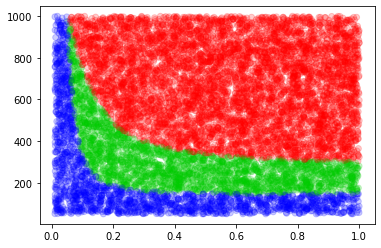

In [49]:
import matplotlib.pyplot as plt

plt.scatter(omqs, deltas, c=colors, alpha=0.2)
plt.show()

более подробно [тут](https://dask.org/)